# Frequentist models with PC1

**Importing required libraries**

In [88]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
#from scipy.sparse import csr_matrix
#from scipy import sparse
from libpysal.weights.util import get_points_array_from_shapefile
from libpysal.weights import Queen
#import contextily as ctx
#import libpysal as lps
import pysal.lib
import pysal.model.spreg
from spreg import ML_Lag, ML_Error, GM_Error
import geopandas as gpd
from libpysal import weights
import matplotlib.pyplot as plt
from pysal.model.spreg import GM_Error_Het
from pysal.lib import weights
from pysal.model import spreg
import seaborn as sn
from sklearn.metrics import mean_squared_error, r2_score

**Importing the datasets**: 
Assigning the file paths of call detail records, remote sensing data, and principle component analysis data to mobile_path, satellite_path, and pca_path respectively

In [89]:
mobile_path = '/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/mobile_features.csv'
satellite_path = '/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/satellite_features.csv'
pca_path = '/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/pca_census.csv'

## Data Cleaning

In [90]:
#Reading Ground truth DATA and filtering zero population gnds (Grama niladhari divisions are referred to as gnd, which are the smallest diviions in Sri Lanka)
data_pca = pd.read_csv(pca_path)
missing_gnd_ids = data_pca.loc[data_pca['PC1'].isnull(), 'gnd_id']
count = missing_gnd_ids.count()
print('No of gnds with zero population:',count)

No of gnds with zero population: 37


In [91]:
# Read the datasets and merge into a single pandas dataframe
data_raw = pd.read_csv(mobile_path).merge(pd.read_csv(satellite_path), on='gnd_id').merge(pd.read_csv(pca_path), on='gnd_id').rename(columns={"PC1": "pc1"}).set_index('gnd_id')

In [92]:
#Removing the zero population gnds from the dataframe
data_raw = data_raw[~data_raw.index.isin(missing_gnd_ids)]

## Data Processing

In [93]:
# Log transform skewed variables

data_unskewed = data_raw[[

    #Call detail records
    "call_count",
    "avg_call_duration",
    "nighttime_call_count",
    "avg_nighttime_call_duration",
    "incoming_call_count",
    "avg_incoming_call_duration",
    "radius_of_gyration",
    "unique_tower_count",
    "spatial_entropy",
    "avg_call_count_per_contact",
    "avg_call_duration_per_contact",
    "contact_count",
    "social_entropy",

    #Remote Sensing data
    "travel_time_major_cities",
    "population_count_worldpop",
    "population_count_ciesin",
    "population_density",
    "aridity_index",
    "evapotranspiration",
    "nighttime_lights",
    "elevation",
    "vegetation",
    "distance_roadways_motorway",
    "distance_roadways_trunk",
    "distance_roadways_primary",
    "distance_roadways_secondary",
    "distance_roadways_tertiary",
    "distance_waterways",
    "urban_rural_fb",
    "urban_rural_ciesin",
    "global_human_settlement",
    "protected_areas",
    "land_cover_woodland",
    "land_cover_grassland",
    "land_cover_cropland",
    "land_cover_wetland",
    "land_cover_bareland",
    "land_cover_urban",
    "land_cover_water",
    "pregnancies",
    "births",
    "precipitation",
    "temperature",

    "pc1"
]].copy()

# Log transform skewed variables
data_unskewed.loc[:, "radius_of_gyration_log"] = np.log(data_unskewed["radius_of_gyration"])
data_unskewed.loc[:, "travel_time_major_cities_log"] = np.log(data_unskewed["travel_time_major_cities"] + 1)
data_unskewed.loc[:, "population_count_worldpop_log"] = np.log(data_unskewed["population_count_worldpop"] + 1)
data_unskewed.loc[:, "population_count_ciesin_log"] = np.log(data_unskewed["population_count_ciesin"] + 1)
data_unskewed.loc[:, "population_density_log"] = np.log(data_unskewed["population_density"])
data_unskewed.loc[:, "elevation_log"] = np.log(data_unskewed["elevation"] + 1)
data_unskewed.loc[:, "distance_roadways_trunk_log"] = np.log(data_unskewed["distance_roadways_trunk"] + 1)
data_unskewed.loc[:, "distance_roadways_primary_log"] = np.log(data_unskewed["distance_roadways_primary"] + 1)
data_unskewed.loc[:, "distance_roadways_secondary_log"] = np.log(data_unskewed["distance_roadways_secondary"] + 1)
data_unskewed.loc[:, "distance_roadways_tertiary_log"] = np.log(data_unskewed["distance_roadways_tertiary"] + 1)
data_unskewed.loc[:, "distance_waterways_log"] = np.log(data_unskewed["distance_waterways"] + 1)
data_unskewed.loc[:, "urban_rural_fb_log"] = np.log(data_unskewed["urban_rural_fb"] + 1)
data_unskewed.loc[:, "global_human_settlement_log"] = np.log(data_unskewed["global_human_settlement"] + 1)
data_unskewed.loc[:, "protected_areas_log"] = np.log(data_unskewed["protected_areas"] + 1)
data_unskewed.loc[:, "land_cover_grassland_log"] = np.log(data_unskewed["land_cover_grassland"] + 1)
data_unskewed.loc[:, "land_cover_wetland_log"] = np.log(data_unskewed["land_cover_wetland"] + 1)
data_unskewed.loc[:, "land_cover_bareland_log"] = np.log(data_unskewed["land_cover_bareland"] + 1)
data_unskewed.loc[:, "land_cover_water_log"] = np.log(data_unskewed["land_cover_water"] + 1)
data_unskewed.loc[:, "pregnancies_log"] = np.log(data_unskewed["pregnancies"])
data_unskewed.loc[:, "births_log"] = np.log(data_unskewed["births"])


#Optional step, consider rs_only variable when conducting the study only with remote sensing data
rs_only = data_unskewed[[
    "travel_time_major_cities_log",
    "population_count_worldpop_log",
    "population_count_ciesin_log",
    "population_density_log",
    "aridity_index",
    "evapotranspiration",
    "nighttime_lights",
    "elevation_log",
    "vegetation",
    "distance_roadways_motorway",
    "distance_roadways_trunk_log",
    "distance_roadways_primary_log",
    "distance_roadways_secondary_log",
    "distance_roadways_tertiary_log",
    "distance_waterways_log",
    "urban_rural_fb_log",
    "urban_rural_ciesin",
    "global_human_settlement_log",
    "protected_areas_log",
    "land_cover_woodland",
    "land_cover_grassland_log",
    "land_cover_cropland",
    "land_cover_wetland_log",
    "land_cover_bareland_log",
    "land_cover_urban",
    "land_cover_water_log",
    "pregnancies_log",
    "births_log",
    "precipitation",
    "temperature",

    "pc1"
]].copy()

#Optional step, consider cdr_only variable when conducting the study only with call detail records

cdr_only = data_unskewed[[
"call_count",
    "avg_call_duration",
    "nighttime_call_count",
    "avg_nighttime_call_duration",
    "incoming_call_count",
    "avg_incoming_call_duration",
    "radius_of_gyration",
    "unique_tower_count",
    "spatial_entropy",
    "avg_call_count_per_contact",
    "avg_call_duration_per_contact",
    "contact_count",
    "social_entropy",
    #principle componanet analysis
    "pc1"
    #"ground_truth" 
]].copy()

#data_unskewed = rs_only.copy()


In [94]:
data_unskewed = data_unskewed.drop(columns=["radius_of_gyration", "travel_time_major_cities", "population_count_worldpop", "population_count_ciesin", "population_density", "elevation", "distance_roadways_trunk", "distance_roadways_primary", "distance_roadways_secondary", "distance_roadways_tertiary", "distance_waterways", "urban_rural_fb", "global_human_settlement", "protected_areas", "land_cover_grassland", "land_cover_wetland", "land_cover_bareland", "land_cover_water", "pregnancies", "births"])

In [95]:
#fill missing values with their mean
data_unskewed.fillna(data_unskewed.mean(), inplace=True)
data_unskewed.isna().sum()

call_count                         0
avg_call_duration                  0
nighttime_call_count               0
avg_nighttime_call_duration        0
incoming_call_count                0
avg_incoming_call_duration         0
unique_tower_count                 0
spatial_entropy                    0
avg_call_count_per_contact         0
avg_call_duration_per_contact      0
contact_count                      0
social_entropy                     0
aridity_index                      0
evapotranspiration                 0
nighttime_lights                   0
vegetation                         0
distance_roadways_motorway         0
urban_rural_ciesin                 0
land_cover_woodland                0
land_cover_cropland                0
land_cover_urban                   0
precipitation                      0
temperature                        0
pc1                                0
radius_of_gyration_log             0
travel_time_major_cities_log       0
population_count_worldpop_log      0
p

## correlation matrix

In [96]:
correlation_matrix = data_unskewed.corr()

# Highly Correlated Covariates
high_correlation_threshold = 0.70
high_correlation_pairs = np.where(np.abs(correlation_matrix) > high_correlation_threshold)

covariates_to_drop = set()
for i, j in zip(*high_correlation_pairs):
    if i != j and i not in covariates_to_drop and j not in covariates_to_drop:
        covariate_i = correlation_matrix.columns[i]
        covariate_j = correlation_matrix.columns[j]
        # Check if 'pc_1' is involved in the pair
        if 'pc_1' in (covariate_i, covariate_j):
            
            if covariate_i != 'pc_1':
                covariates_to_drop.add(covariate_i)
            if covariate_j != 'pc_1':
                covariates_to_drop.add(covariate_j)
        else:
            # Choose which covariate to drop based on your criteria
            # For example, drop the one with lower relevance
            # or keep the one with higher theoretical importance
            # or drop the one that contributes less to the analysis
            # Here, we simply drop the one with higher index
            if i > j:
                covariates_to_drop.add(covariate_i)
            else:
                covariates_to_drop.add(covariate_j)




In [97]:
covariates_to_drop

{'avg_call_count_per_contact',
 'avg_incoming_call_duration',
 'avg_nighttime_call_duration',
 'births_log',
 'contact_count',
 'distance_roadways_primary_log',
 'distance_roadways_tertiary_log',
 'global_human_settlement_log',
 'incoming_call_count',
 'land_cover_cropland',
 'land_cover_urban',
 'nighttime_call_count',
 'nighttime_lights',
 'pc1',
 'population_count_ciesin_log',
 'population_density_log',
 'precipitation',
 'travel_time_major_cities_log',
 'unique_tower_count',
 'urban_rural_fb_log'}

#### Removing highly correlated variables

In [98]:
covariates_to_drop = {
    'avg_call_count_per_contact',
    'distance_roadways_tertiary_log',
    'global_human_settlement_log',
    'precipitation',
    'unique_tower_count',
    'urban_rural_fb_log'}

data_unskewed = data_unskewed.drop(columns=covariates_to_drop)

# Verify Multicollinearity Reduction (optional)
#correlation_matrix_cleaned = df_cleaned.corr()

## Data stratification based on Province

In [99]:
'''
The province id is included in every gnd id's first digit 

ex: if gnd id starts with 23405....
    its corresponding province id is 2

Below data stratification is done as to represent 80 percent of gnds within a province

'''

province = data_unskewed.index.astype(str).str[0] 


X_train, X_test, y_train, y_test = train_test_split(data_unskewed.drop(columns=["pc1"]), data_unskewed["pc1"], stratify=province, test_size=0.2)

In [100]:
''' 
Normalize and remove highly correlated and near-zero variance variables (scaling the data to have a mean of 0 and a standard deviation of 1)
'''

scaler_train = StandardScaler()
data_train_scaled = scaler_train.fit_transform(X_train)

scaler_test = StandardScaler()
data_test_scaled = scaler_test.fit_transform(X_test)

scaler_full = StandardScaler()
data_full_scaled = scaler_full.fit_transform(data_unskewed.drop(columns="pc1"))

# Convert the scaled data back to a DataFrame
data_full_scaled = pd.DataFrame(data_full_scaled, columns=data_unskewed.columns.drop("pc1"))
data_full_scaled["pc1"] = data_unskewed["pc1"]

data_train_scaled = pd.DataFrame(data_train_scaled, columns=X_train.columns)
data_train_scaled.index = X_train.index


data_test_scaled = pd.DataFrame(data_test_scaled, columns=X_test.columns)
data_test_scaled.index = X_test.index

#data_train_scaled = x train
#data_test_scaled = x test



## Processing Sri Lanka shapefile

In [101]:
data_shapefile = gpd.read_file("/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/sri_lanka_gnd_shape_files/sri_lanka_gnd.shp")

#In the shape file, code_7 column corresponds to the gnd id
data_shapefile.set_index("code_7", inplace=True)
data_shapefile = data_shapefile.to_crs(epsg=3857)

In [102]:
#total data merge with the shapefile
merged = data_unskewed.merge(data_shapefile, left_on=data_unskewed.index, right_on='code_7', how='inner')
gdf = gpd.GeoDataFrame(merged, geometry='geometry', crs=data_shapefile.crs)
gdf = gdf.to_crs(epsg=3857)
merged = merged.drop(columns=['prov_name','dist_name', 'dsd_name', 'gnd_name'])

#train set merge with the shapefile
merged_train = data_train_scaled.merge(data_shapefile, left_on=data_train_scaled.index, right_on='code_7', how='inner')
gdf_train = gpd.GeoDataFrame(merged_train, geometry='geometry', crs=data_shapefile.crs)
gdf_train = gdf_train.to_crs(epsg=3857)
merged_train = merged_train.drop(columns=['prov_name','dist_name', 'dsd_name', 'gnd_name'])

#test data merge with the shapefile
merged_test = data_test_scaled.merge(data_shapefile, left_on=data_test_scaled.index, right_on='code_7', how='inner')
gdf_test = gpd.GeoDataFrame(merged_test, geometry='geometry', crs=data_shapefile.crs)
gdf_test = gdf_test.to_crs(epsg=3857)
merged_test = merged_test.drop(columns=['prov_name','dist_name', 'dsd_name', 'gnd_name'])



**The Sri Lankan map**: Red indicates gnds with population, while gray indicates the gnds with zero population

(8854053.430712115, 9126918.94253964, 638018.8213061832, 1122278.6930524309)

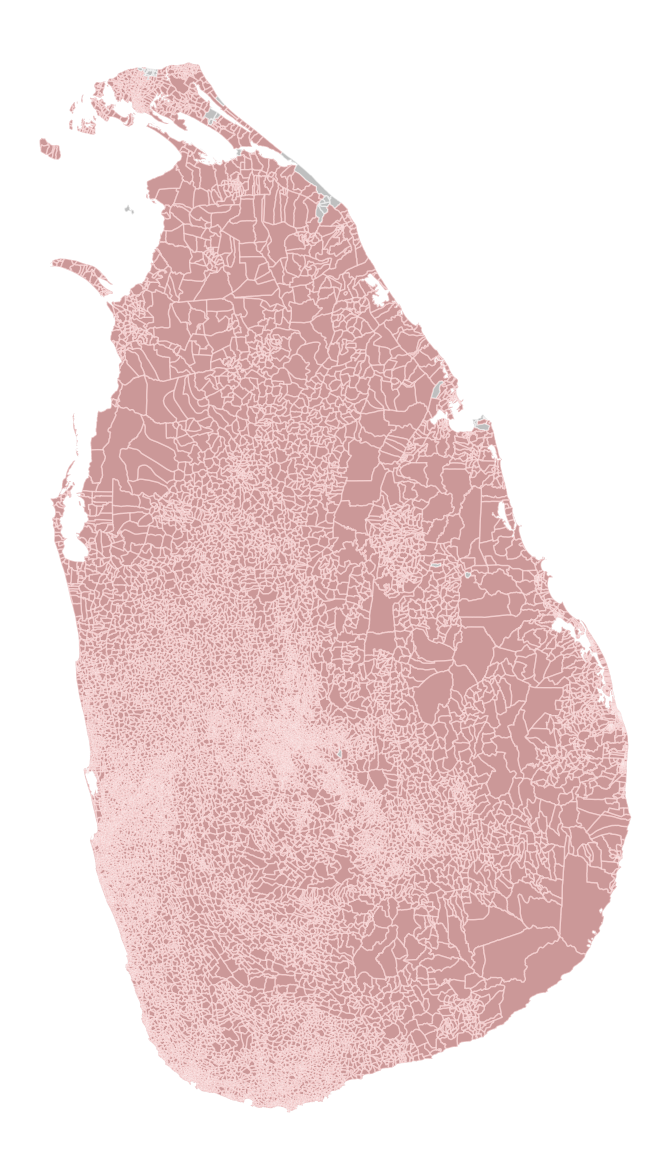

In [103]:
fig, ax = plt.subplots(1,1,figsize=(15, 15))

data_shapefile.plot(ax=ax,
        color='gray', 
        edgecolor='white',
        alpha=0.5)

gdf.plot(ax=ax, 
            color='red',
            markersize=1,
            alpha=0.2)

ax.axis('off')

# Ground Truth Map

Data obtained from principle component analysis

Text(0.5, 1.0, 'Ground truth map')

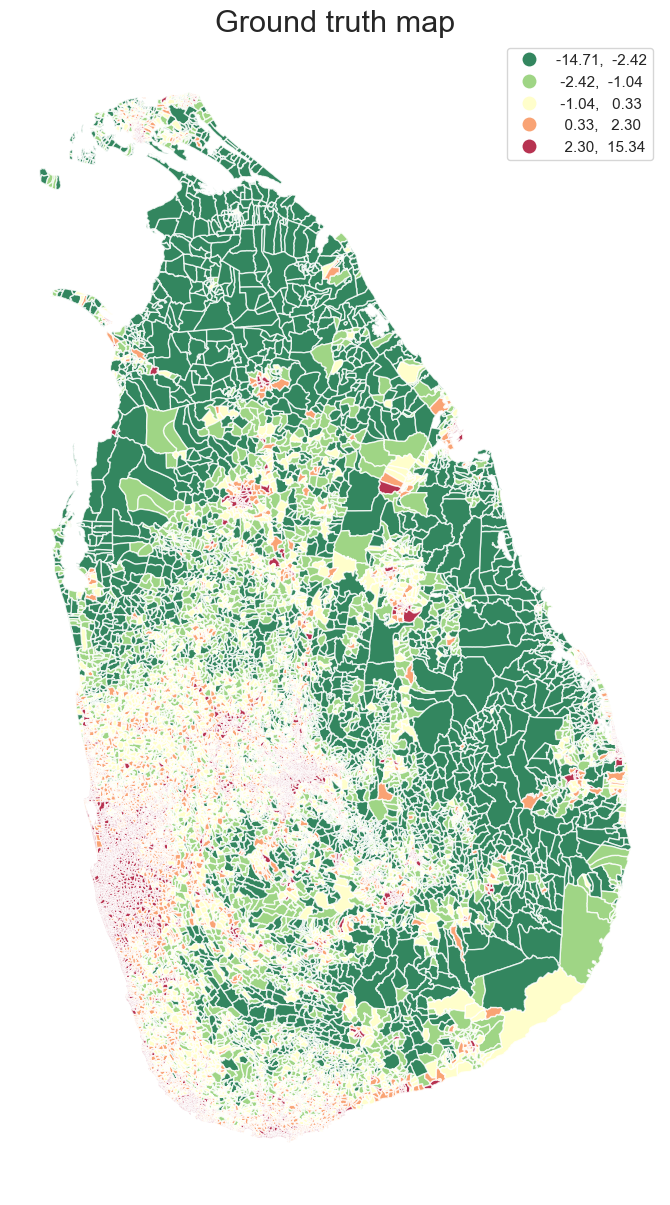

In [104]:
fig,ax = plt.subplots(figsize=(15,15))

gdf.plot(ax=ax,
        column='pc1',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles') 

ax.axis('off')
ax.set_title('Ground truth map',fontsize=22)

## Modeling

We begin with a standard linear regression model, devoid of any geographical reference. From there, we formalize space and spatial relationships in three main ways: first, encoding it in exogenous variables; second, through spatial heterogeneity, or as systematic variation of outcomes across space; third, as dependence, or through the effect associated to the characteristics of spatial neighbors.

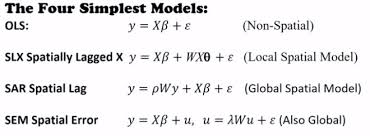


### 1. **Spatial Error Model (SEM)**

This model assumes that the error terms are spatially correlated, which means that the error at one location depends on the errors at nearby locations.

**Model Specification:**
\[ y = X\beta + u \]
\[ u = \lambda Wu + \epsilon \]


### 2. **Spatial Lag Model (SLM)**

The Spatial Lag Model (SLM) incorporates spatial dependence directly into the dependent variable. This model assumes that the value of the dependent variable at one location depends on the values of the dependent variable at neighboring locations.

**Model Specification:**
\[ y = \rho Wy + X\beta + \epsilon \]


### 3. **Spatial Durbin Error Model (SDEM)**

The Spatial Durbin Error Model (SDEM) extends the Spatial Error Model by including both spatial lags of the independent variables and spatially autocorrelated errors. This model captures both the direct and indirect effects of the independent variables, considering spatial spillovers.

**Model Specification:**
\[ y = X\beta + WX\theta + u \]
\[ u = \lambda Wu + \epsilon \]


## Ordinary Least Squares Model

In [105]:
'''
Adding a constant to allow the model to fit an intercept term.
'''
X_train_ols = sm.add_constant(data_train_scaled)

model = sm.OLS(y_train, X_train_ols)
model_OLS = model.fit()

print(model_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                    pc1   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     891.3
Date:                Sun, 07 Jul 2024   Prob (F-statistic):               0.00
Time:                        20:41:06   Log-Likelihood:                -21541.
No. Observations:               11188   AIC:                         4.316e+04
Df Residuals:                   11150   BIC:                         4.344e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [106]:
X_test_ols = sm.add_constant(data_test_scaled)
y_pred = model_OLS.predict(X_test_ols)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 2.8120486320200957
R-squared: 0.7383498638895839


In general, our model performs well, with a R squared value of 0.759. Since OLS models assumes independence of observations, which can lead to biased estimates and incorrect inferences in spatial data. Therefore Spatial models are preferred over OLS when studying spatial distribution because they account for spatial autocorrelation, where nearby locations tend to influence each other. Spatial models, like spatial lag or error models, and Spatial Durbin error models, consider this interdependence, enhancing our understanding of how spatial patterns influence the variable of interest and leading to more accurate and robust analyses, even if OLS provides a high R-squared value.
 

### Processing data for Spatial Models

In [107]:
'''
Step 01: Creating spatial weights matrix
Step 02: Convertiing the weights matrix to a sparse matrix for use in spreg
'''
w = weights.Queen.from_dataframe(merged_train)
w.transform = 'r'

/var/folders/qq/v15mxgl96rjgk1x2qkhfzvlh0000gn/T/ipykernel_21013/2679821026.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(merged_train)


('WARNING: ', 95, ' is an island (no neighbors)')
('WARNING: ', 456, ' is an island (no neighbors)')
('WARNING: ', 794, ' is an island (no neighbors)')
('WARNING: ', 826, ' is an island (no neighbors)')
('WARNING: ', 2753, ' is an island (no neighbors)')
('WARNING: ', 5077, ' is an island (no neighbors)')
('WARNING: ', 5204, ' is an island (no neighbors)')
('WARNING: ', 5562, ' is an island (no neighbors)')
('WARNING: ', 6842, ' is an island (no neighbors)')
('WARNING: ', 7956, ' is an island (no neighbors)')
('WARNING: ', 8040, ' is an island (no neighbors)')
('WARNING: ', 9514, ' is an island (no neighbors)')
('WARNING: ', 10895, ' is an island (no neighbors)')


/Users/chanukaalgama/anaconda3/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 32 disconnected components.
 There are 13 islands with ids: 95, 456, 794, 826, 2753, 5077, 5204, 5562, 6842, 7956, 8040, 9514, 10895.
  W.__init__(self, neighbors, ids=ids, **kw)


#### There are 62 islands in Sri Lanka

Since these regions do not share boundaries with any other regions according to the spatial weights matrix. These islands can affect the spatial model's performance and interpretation.

**Approaches to Handle Islands**

1. Connect Islands to Nearest Neighbors

2. Remove Islands from the analysis

3. Use KNN instead of contiguity-based weights, so that for each observation we can have a fixed number of neighbors.


In [108]:
# Creating spatial weights matrix using KNN
#for train dataset
w = pysal.lib.weights.KNN.from_dataframe(merged_train)

#for full dataset
w_full = pysal.lib.weights.KNN.from_dataframe(merged)

/Users/chanukaalgama/anaconda3/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 49 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/Users/chanukaalgama/anaconda3/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 22 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


## Spatial Error Model (SEM)

In [109]:
'''
model_SEM = spreg.ML_Error(y_train, X_train_scaled.values, w=w, name_x=['const'] + list(X_train_scaled.columns))
print(model_SEM.summary)
'''

#SEM inferencing model

#sem_model = pysal.model.spreg.GM_Error(y_train.values, data_train_scaled.values, w=w, name_y='ground_truth', name_x=data_train_scaled.columns.tolist())

sem_model = pysal.model.spreg.GM_Error(data_unskewed['pc1'].values, data_unskewed.drop(columns=['pc1']).values, w=w_full, name_y='ground_truth', name_x=data_train_scaled.columns.tolist())
print(sem_model.summary)



REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES
------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :ground_truth                Number of Observations:       13985
Mean dependent var  :     -0.0003                Number of Variables   :          38
S.D. dependent var  :      3.2969                Degrees of Freedom    :       13947
Pseudo R-squared    :      0.7411

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT     41060.46222    
          call_count         0.00299         0.00058         5.19273         0.00000
   avg_call_duration         0.00690         0.00757         0.91167         0.36195
nighttime_call_count       

/Users/chanukaalgama/anaconda3/lib/python3.11/site-packages/spreg/error_sp.py:117: RuntimeWarning: invalid value encountered in sqrt
  se_betas = np.sqrt(self.vm.diagonal())
/Users/chanukaalgama/anaconda3/lib/python3.11/site-packages/spreg/diagnostics.py:354: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
/Users/chanukaalgama/anaconda3/lib/python3.11/site-packages/spreg/diagnostics.py:170: RuntimeWarning: invalid value encountered in sqrt
  ) / np.sqrt(variance)


## Spatial Lag Error Model (SLX)

In [113]:
# SLX model
slx_model = pysal.model.spreg.ML_Lag(data_unskewed['pc1'].values, data_unskewed.drop(columns=['pc1']).values, w=w_full, name_y='ground_truth', name_x=data_train_scaled.columns.tolist())
print(slx_model.summary)

/Users/chanukaalgama/anaconda3/lib/python3.11/site-packages/spreg/ml_lag.py:661: RuntimeWarning: divide by zero encountered in log
  jacob = np.log(np.linalg.det(a))


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :ground_truth                Number of Observations:       13985
Mean dependent var  :     -0.0003                Number of Variables   :          39
S.D. dependent var  :      3.2969                Degrees of Freedom    :       13946
Pseudo R-squared    :      0.8028
Spatial Pseudo R-squared:  0.7251
Log likelihood      : -25937.6145
Sigma-square ML     :      2.1490                Akaike info criterion :   51953.229
S.E of regression   :      1.4660                Schwarz criterion     :   52247.513

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

/Users/chanukaalgama/anaconda3/lib/python3.11/site-packages/spreg/diagnostics.py:354: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
/Users/chanukaalgama/anaconda3/lib/python3.11/site-packages/spreg/diagnostics.py:170: RuntimeWarning: invalid value encountered in sqrt
  ) / np.sqrt(variance)


## Spatial Durbin Error Model (SDEM)

In [114]:

model_SDEM = GM_Error_Het(data_unskewed['pc1'].values, data_unskewed.drop(columns=['pc1']).values, w=w_full, name_y='ground_truth', name_x=data_train_scaled.columns.tolist())
print(model_SDEM.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES (HET)
------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :ground_truth                Number of Observations:       13985
Mean dependent var  :     -0.0003                Number of Variables   :          38
S.D. dependent var  :      3.2969                Degrees of Freedom    :       13947
Pseudo R-squared    :      0.6283
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    -423982.88369    
          call_count         0.00589         0.00082         7.17055         0.00000
   avg_call_du

/Users/chanukaalgama/anaconda3/lib/python3.11/site-packages/spreg/diagnostics.py:354: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
/Users/chanukaalgama/anaconda3/lib/python3.11/site-packages/spreg/diagnostics.py:170: RuntimeWarning: invalid value encountered in sqrt
  ) / np.sqrt(variance)


## Model Comparison (SEM VS SLX VS SDEM)

**The most common statistical methods to compare spatial models**

1. **Akaike Information Criterion (AIC)** : A lower AIC value generally indicates a better model.
2.  **Bayesian Information Criterion (BIC)**: A lower BIC value generally indicates a better model.
3. **Log-Likelihood** : This is a measure of how well the model explains the data. Higher log-likelihood values indicate a better fit.


**Computation**

AIC (Akaike Information Criterion) = 2k - 2ln(L)

BIC (Bayesian Information Criterion) = kln(n) - 2ln(L)

where,

k is the number of parameters
L is the maximized value of the likelihood function of the model
n is the number of observations

In [ ]:
# residuals for SEM model
residuals_sem = sem_model.y - sem_model.predy
# residuals for SLX model
residuals_slx = slx_model.y - slx_model.predy

# Log-Likelihood for SEM
mse_sem = mean_squared_error(sem_model.y.flatten(), sem_model.predy.flatten())
llf_sem = -0.5 * len(sem_model.y) * np.log(2 * np.pi * mse_sem) - 0.5 * np.sum(np.array(residuals_sem)**2) / mse_sem

# Log-Likelihood for SLX
mse_slx = mean_squared_error(slx_model.y.flatten(), slx_model.predy.flatten())
llf_slx = -0.5 * len(slx_model.y) * np.log(2 * np.pi * mse_slx) - 0.5 * np.sum(np.array(residuals_slx)**2) / mse_slx

k_sem = len(sem_model.betas)
k_slx = len(slx_model.betas)

aic_sem = 2.0*k_sem - 2*llf_sem

bic_sem = np.log(len(sem_model.y))*k_sem - 2*llf_sem

aic_slx = 2.0*k_slx - 2*llf_slx

bic_slx = np.log(len(slx_model.y))*k_slx - 2*llf_slx


In [ ]:
# residuals for SDEM model
residuals_sdem = model_SDEM.y - model_SDEM.predy

mse_sdem = mean_squared_error(model_SDEM.y.flatten(), model_SDEM.predy.flatten())

llf_sdem = -0.5 * len(model_SDEM.y) * np.log(2 * np.pi * mse_sdem) - 0.5 * np.sum(np.array(residuals_sdem)**2) / mse_sdem

k_sdem = len(model_SDEM.betas)

aic_sdem = 2.0*k_sdem - 2*llf_sdem


bic_sdem = np.log(len(model_SDEM.y))*k_sdem - 2*llf_sdem

In [35]:
print('AIC')
print('SEM AIC: ', aic_sem)
print('SLX AIC: ', aic_slx)
#print('SDEM AIC: ', aic_sdem)


print('BIC')
print('SEM BIC: ', bic_sem)
print('SLX BIC: ', bic_slx)
#print('SDEM BIC: ', bic_sdem)


AIC
SEM AIC:  5736.688081911312
SLX AIC:  -6980.342647371466
BIC
SEM BIC:  6083.8053048432275
SLX BIC:  -6633.225424439551


**Selection**

According to these criteria, SLX model appears to be the best performing model. However, since we are more interested in **Spatial error effect** rather than **Spatial lag effect** the selection among SEM or SDEM model is more appropriate. So considering the above AIC/ BIC criteria, SDEM model is selected as the best performing model.



## Results visualization 

In [120]:
merged['pred_ground_truth'] = sem_model.predy.flatten()

Text(0.5, 1.0, '')

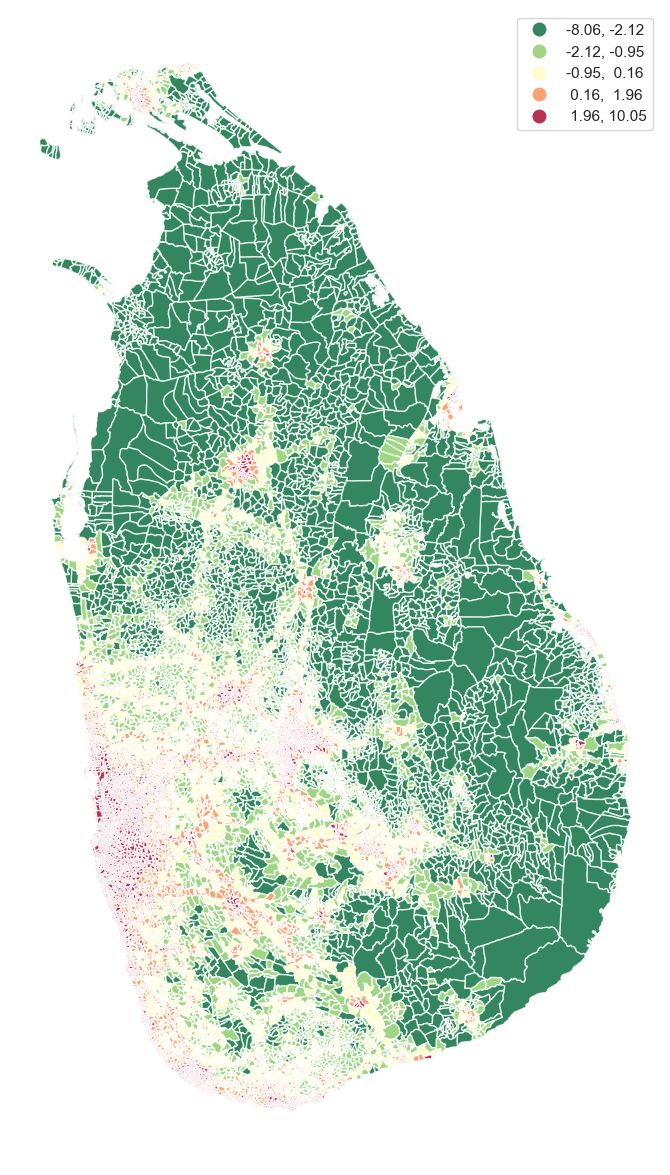

In [121]:
#merged = data_unskewed.merge(data_shapefile, left_on=data_unskewed.code_7, right_on='code_7', how='inner')
gdf = gpd.GeoDataFrame(merged, geometry='geometry', crs=data_shapefile.crs)
gdf = gdf.to_crs(epsg=3857)

fig,ax = plt.subplots(figsize=(15,15))

gdf.plot(ax=ax,
        column='pred_ground_truth',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles') 

ax.axis('off')
ax.set_title('',fontsize=22)

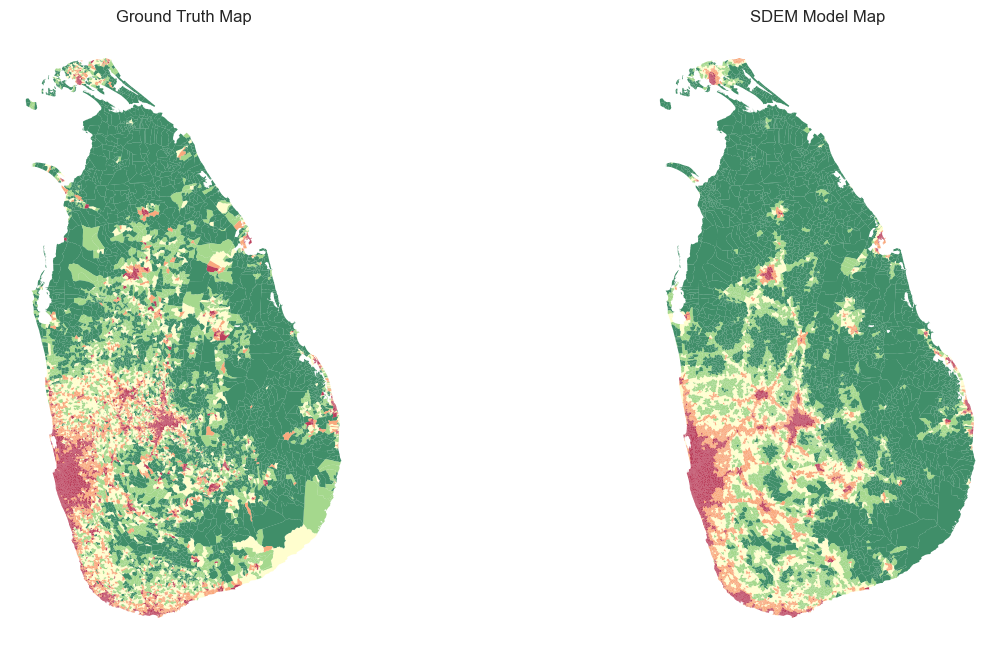

In [123]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

gdf.plot(ax=ax[0],
         column='pc1', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Ground Truth Map")


gdf.plot(ax=ax[1],
         column='pred_ground_truth', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("SDEM Model Map")

plt.show()

Prediction of top 50%

In [ ]:
data_unskewed.sort_values(by=['ground_truth'])

In [51]:
top_25_percent = int(0.25 * len(data_unskewed))
df_top_25 = data_unskewed.iloc[:top_25_percent]

index_values_top_25 = df_top_25.index.values

df_top_25 = gdf.loc[index_values_top_25]

actual_values = df_top_25['ground_truth']
predicted_values = df_top_25['pred_ground_truth']


r2 = r2_score(actual_values, predicted_values)

r2

0.42096667239122776